In [1]:
%matplotlib inline
import pandas as pd
import cvxportfolio as cp

Download the problem data with `yfinance`. We select five liquid stocks.

In [2]:
import yfinance
tickers = ["AMZN", "AAPL", "MSFT", "GOOGL", "TSLA"]
data = {ticker: yfinance.download(ticker) for ticker in tickers}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
returns = pd.DataFrame({ticker: data[ticker]['Adj Close'].pct_change() for ticker in tickers})
volumes = pd.DataFrame({ticker: data[ticker]['Volume'] * data[ticker]['Close'] for ticker in tickers})

In [4]:
returns.describe()

,AMZN,AAPL,MSFT,GOOGL,TSLA
count,6516.000000,10668.000000,9342.000000,4690.000000,3215.000000
mean,0.001706,0.001100,0.001136,0.000991,0.002130
std,0.036090,0.028219,0.021318,0.019436,0.036154
min,-0.247661,-0.518692,-0.301159,-0.116341,-0.210628
25%,-0.013288,-0.013062,-0.009217,-0.007982,-0.015604
50%,0.000402,0.000000,0.000352,0.000755,0.001221
75%,0.014802,0.014705,0.011358,0.010082,0.019391
max,0.344714,0.332281,0.195652,0.199915,0.243951


In [5]:
volumes.describe()

,AMZN,AAPL,MSFT,GOOGL,TSLA
count,6.517000e+03,1.066900e+04,9.343000e+03,4.691000e+03,3.216000e+03
mean,2.725410e+09,2.922022e+09,1.899162e+09,2.294151e+09,6.461023e+09
std,4.255222e+09,4.519733e+09,2.263382e+09,1.494585e+09,1.055820e+10
min,8.935645e+05,0.000000e+00,2.348990e+05,2.079860e+08,2.470725e+06
25%,3.092570e+08,4.958471e+07,3.193753e+08,1.304535e+09,5.732500e+08
50%,8.026035e+08,1.832336e+08,1.391419e+09,1.873122e+09,1.519953e+09
75%,2.889868e+09,4.653319e+09,2.209604e+09,2.808775e+09,7.866425e+09
max,3.995468e+10,4.353884e+10,2.683116e+10,1.823360e+10,1.543777e+11


We get the return on cash from FRED.

In [6]:
import pandas_datareader

returns[["USDOLLAR"]] =  pandas_datareader.get_data_fred("DFF", start='2000-01-01') / (250 * 100)
returns = returns.fillna(method="ffill").dropna()

returns.tail()

,AMZN,AAPL,MSFT,GOOGL,TSLA,USDOLLAR
Date,,,,,,
2023-03-31,0.012647,0.015644,0.014962,0.028150,0.062372,0.000193
2023-04-03,-0.008520,0.007702,-0.003711,0.006073,-0.061168,0.000193
2023-04-04,0.015038,-0.003250,-0.000174,0.003450,-0.011244,0.000193
2023-04-05,-0.027417,-0.011290,-0.009889,-0.002387,-0.036660,0.000193
2023-04-06,0.009496,0.005496,0.025533,0.037810,-0.002480,0.000193


We compute rolling estimates of the first and second moments of the returns using a window of 1000 days. We shift them by one unit (so at every day we present the optimizer with only past data).

In [7]:
r_hat = returns.rolling(window=1000).mean().shift(1).dropna()
Sigma_hat = returns.shift(1).rolling(window=1000).cov().dropna()

r_hat

,AMZN,AAPL,MSFT,GOOGL,TSLA,USDOLLAR
Date,,,,,,
2014-06-20,0.001314,0.001108,0.000786,0.001036,0.002961,0.000005
2014-06-23,0.001300,0.001116,0.000803,0.001059,0.002971,0.000005
2014-06-24,0.001293,0.001127,0.000804,0.001085,0.003083,0.000005
2014-06-25,0.001300,0.001127,0.000794,0.001089,0.003189,0.000005
2014-06-26,0.001302,0.001121,0.000777,0.001113,0.003368,0.000005
...,...,...,...,...,...,...
2023-03-31,0.000361,0.001441,0.001107,0.000732,0.003286,0.000048
2023-04-03,0.000376,0.001465,0.001121,0.000758,0.003376,0.000048
2023-04-04,0.000368,0.001473,0.001112,0.000753,0.003317,0.000048


In [8]:
Sigma_hat

AMZN          AAPL          MSFT         GOOGL  \
Date                                                                          
2014-06-20 AMZN      4.237160e-04  1.014462e-04  9.996411e-05  1.531471e-04   
           AAPL      1.014462e-04  2.841139e-04  7.152263e-05  1.037270e-04   
           MSFT      9.996411e-05  7.152263e-05  1.983344e-04  8.818661e-05   
           GOOGL     1.531471e-04  1.037270e-04  8.818661e-05  2.528908e-04   
           TSLA      2.003648e-04  1.220264e-04  1.074350e-04  1.364906e-04   
...                           ...           ...           ...           ...   
2023-04-06 AAPL      3.195569e-04  4.661095e-04  3.415259e-04  3.155694e-04   
           MSFT      3.274855e-04  3.415259e-04  4.113642e-04  3.398828e-04   
           GOOGL     3.208216e-04  3.155694e-04  3.398828e-04  4.366007e-04   
           TSLA      4.526107e-04  4.703269e-04  4.169269e-04  3.822836e-04   
           USDOLLAR -2.052149e-08 -1.379740e-08  3.710382e-09 -2.227037e-08   

                             TSLA      USDOLLAR  
Date                                             
2014-06-20 AMZN      2.003648e-04  9.720131e-10  
           AAPL      1.220264e-04 -6.378224e-10  
           MSFT      1.074350e-04 -7.019010e-10  
           GOOGL     1.364906e-04  2.541239e-10  
           TSLA      1.424632e-03 -6.411383e-10  
...                           ...           ...  
2023-04-06 AAPL      4.703269e-04 -1.379740e-08  
           MSFT      4.169269e-04  3.710382e-09  
           GOOGL     3.822836e-04 -2.227037e-08  
           TSLA      1.854000e-03 -1.129021e-07  
           USDOLLAR -1.129021e-07  3.227362e-09  

[13290 rows x 6 columns]

For the cash return instead we simply use the previous day's return.

In [9]:
r_hat['USDOLLAR'] = returns['USDOLLAR'].shift(1)

Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

In [10]:
sigma = returns.iloc[:,:-1].rolling(window=1000).std().dropna()

In [11]:
sigma

,AMZN,AAPL,MSFT,GOOGL,TSLA
Date,,,,,
2014-06-19,0.020584,0.016856,0.014083,0.015903,0.037744
2014-06-20,0.020586,0.016849,0.014077,0.015888,0.037744
2014-06-23,0.020583,0.016844,0.014077,0.015887,0.037668
2014-06-24,0.020578,0.016843,0.014078,0.015886,0.037454
2014-06-25,0.020579,0.016842,0.014061,0.015902,0.037095
...,...,...,...,...,...
2023-03-31,0.022911,0.021585,0.020279,0.020897,0.042996
2023-04-03,0.022912,0.021585,0.020279,0.020895,0.043044
2023-04-04,0.022917,0.021586,0.020279,0.020895,0.043046


In [12]:
cp.TcostModel?

Init signature:
cp.TcostModel(
    half_spread,
    nonlin_coeff=0.0,
    sigma=0.0,
    volume=1.0,
    power=1.5,
)
Docstring:     
A model for transaction costs.

(See figure 2.3 in the paper
https://stanford.edu/~boyd/papers/pdf/cvx_portfolio.pdf)

Attributes:
  volume: A dataframe of volumes.
  sigma: A dataframe of daily volatilities.
  half_spread: A dataframe of bid-ask spreads divided by 2.
  nonlin_coeff: A dataframe of coefficients for the nonlinear cost.
  power: The nonlinear tcost power.
File:           ~/repos/cvxportfolio/cvxportfolio/costs.py
Type:           type
Subclasses:     

In [13]:
tcost_model = cp.TcostModel(half_spread=10e-4, nonlin_coeff=1., sigma=sigma, volume=volumes.dropna())
hcost_model = cp.HcostModel(borrow_costs=1e-4)

We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [14]:
risk_model = cp.FullSigma(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 5.0, 1.0, 1.0
leverage_limit = cp.LeverageLimit(3)

terminal_weights = pd.Series(0., returns.columns)
terminal_weights['USDOLLAR'] = 1.

trading_times = returns.index[returns.index >= '2023-03-01']
trading_times = trading_times[trading_times <= '2023-03-31']


mpo_policy = cp.MultiPeriodOpt(
    trading_times = trading_times,
    terminal_weights=terminal_weights, 
    lookahead_periods=25, # a month
    return_forecast=cp.ReturnsForecast(r_hat),
    costs=[
        gamma_risk * risk_model,
        gamma_trade * tcost_model,
        gamma_hold * hcost_model,
    ],
    constraints=[leverage_limit],
)

We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

In [15]:
import numpy as np

tw = np.ones(len(tickers)+1)
tw[:-1] = -1/(22 * len(tickers))
tw[-1] = 0 - sum(tw[:-1])

fixedtrade = cp.FixedTrade(tradeweight=pd.Series(tw, returns.columns))

In [16]:


market_sim = cp.MarketSimulator(
    returns, [tcost_model, hcost_model], cash_key="USDOLLAR"
)
init_portfolio = pd.Series(index=returns.columns, data=1E9)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(
    init_portfolio,
    start_time="2023-03-01",
    end_time="2023-03-31",
    policies=[mpo_policy, 
             fixedtrade,
            ],
)
results[0].summary()

/Users/a13333q/Library/Caches/pypoetry/virtualenvs/cvxportfolio-xwxlh7-F-py3.11/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Number of periods                                23
Initial timestamp               2023-03-01 00:00:00
Final timestamp                 2023-03-31 00:00:00
Portfolio return (%)                          3.156
Excess return (%)                            -1.526
Excess risk (%)                               8.816
Sharpe ratio                                 -0.177
Max. drawdown                                 2.114
Turnover (%)                              1,221.713
Average policy time (sec)                     0.148
Average simulator time (sec)                  0.001


<Axes: >

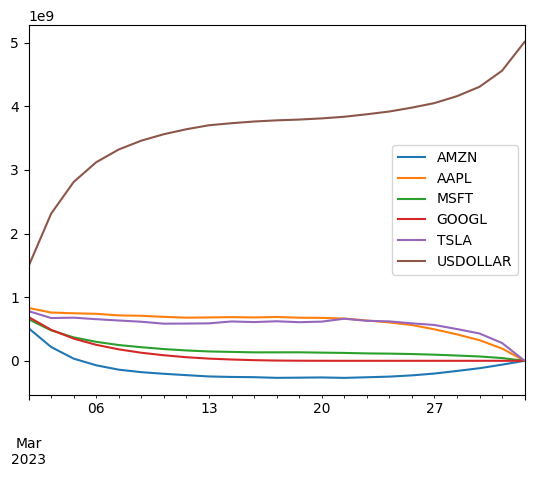

In [17]:
results[0].h_next.plot()

<Axes: >

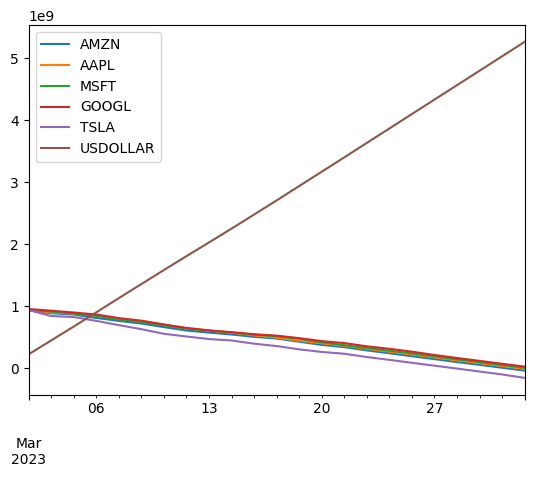

In [18]:
results[1].h_next.plot()

The total value of the portfolio in time.

The weights vector of the portfolio in time.

<Axes: >

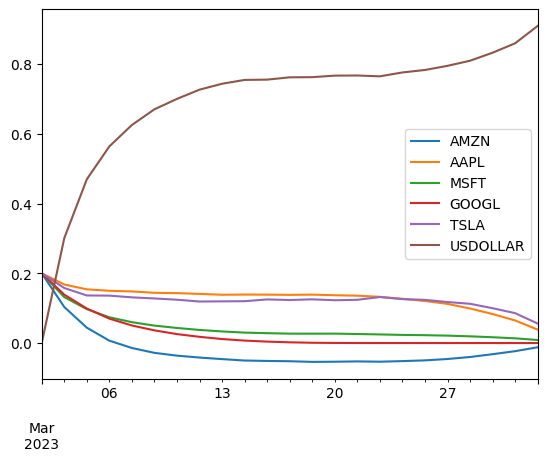

In [19]:
results[0].w.plot()#figsize=(12, 6))

<Axes: >

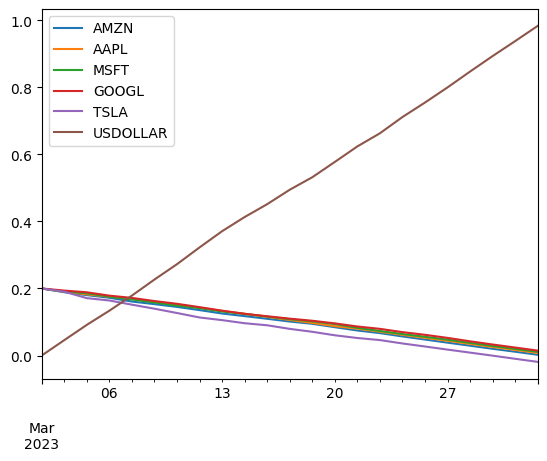

In [20]:
results[1].w.plot()#figsize=(12, 6))